In [1]:
%matplotlib inline

# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from os import listdir
from os.path import isfile, join

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
def preprocess_df(data, col_name):
    data = data[data.체결시각 != 31000000]
    data.일자     = data.일자.astype(str)
    data.종목코드 = data.종목코드.astype(str).str.zfill(6)
    data.체결시각 = data.체결시각.astype(str).str.zfill(8)
    data["거래대금"] = data.현재가 * data.체결수량
    data.index = pd.to_datetime(data.일자 + data.체결시각, format="%Y%m%d%H%M%S%f")
    data.index.name = "시각"    
    return data[set(col_name + ["거래대금"]) - set(["일자", "체결시각"])]

def read_all_csv(path, col_name):
    df = pd.DataFrame([])
    files = [f for f in listdir(path) if isfile(join(path, f))]
    for file in files:
        data = pd.read_csv(path + "/"+file, names = col_name)
        df = pd.concat([df, data], axis = 0)
    return df

In [3]:
def signed_tick(df, initial_value = 1.0):
    diff = df["현재가"] - df["현재가"].shift(1)
    return (abs(diff) / diff).ffill().fillna(initial_value)

In [4]:
def time_bar(df, time):
    resample = df.resample(time)
    bars = resample["현재가"].ohlc()
    bars.fillna(method = "ffill",inplace = True)
    bars[["volume", "value"]] = resample[["체결수량", "거래대금"]].sum()
    return bars

In [5]:

def getBeta(series,sl):
    h1=series[['High','Low']].values
    h1=np.log(h1[:,0]/h1[:,1])**2
    h1=pd.Series(h1,index=series.index)
    beta=h1.rolling(2).sum()
    beta=beta.rolling(sl).mean()
    return beta.dropna()
#----------------------------------

def getGamma(series):
    h2=series['High'].rolling(2).max()
    l2=series['Low'].rolling(2).min()
    gamma=np.log(h2.values/l2.values)**2
    gamma=pd.Series(gamma,index=h2.index)
    return gamma.dropna()

#------------------------------------
def getAlpha(beta,gamma):
    den=3-2*2**.5
    alpha=(2**.5-1)*(beta*.5)/den
    alpha-=(gamma/den)**.5
    alpha[alpha<0]=0 # set netative alphas to 0
    return alpha.dropna()

#--------------------------------
def corwinSchultz(series,sl=1):
    #Note:S<0 iff alpha<0
    beta=getBeta(series,sl)
    gamma=getGamma(series)
    alpha=getAlpha(beta,gamma)
    spread=2*(np.exp(alpha)-1)/(1+np.exp(alpha))
    startTime=pd.Series(series.index[0:spread.shape[0]],index=spread.index)
    spread=pd.concat([spread,startTime],axis=1)
    spread.columns=['Spread','Start_time']# 1st loc used to compute beta
    return spread

#------------------------------
def getSigma(beta,gamma):
    k2=(8/np.pi)**.5
    den=3-2*2**.5
    sigma=(2**-.5-1)*beta**.5/(k2*den)
    sigma+=(gamma/(k2**2*den))**.5
    sigma[sigma<0]=0
    return sigma

#--------------------------------

In [6]:
col_name = ["일자", "종목코드", "체결시각", "체결수량", "현재가", "매도최우선호가", "매수최우선호가" ,"매도최우선호가잔량", "매수최우선호가잔량", 
            "매도10단계호가잔량합", "매수10단계호가잔량합", "매도성향체결수량", "매수성향체결수량"]
data = read_all_csv("samsung_tick", col_name)
data = preprocess_df(data, col_name)
data_5M = time_bar(data, "5T")
data_5M.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Value']

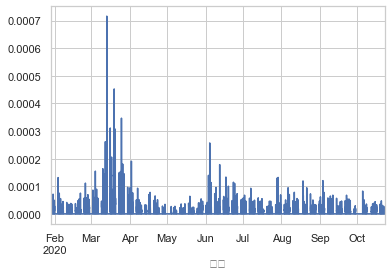

In [7]:
beta = getBeta(data_5M, 10)
beta.plot()

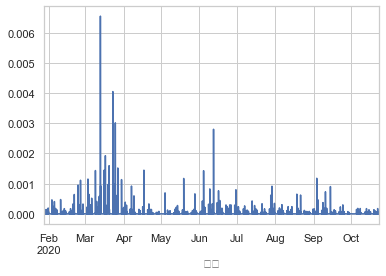

In [8]:
gamma = getGamma(data_5M)
gamma.plot()

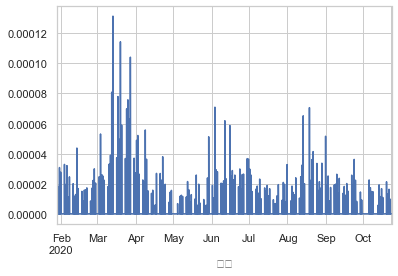

In [9]:
alpha = getAlpha(beta, gamma)
alpha.plot()

In [10]:
corwinSchultz(data_5M)

,Spread,Start_time
시각,,
2020-01-28 09:05:00,0.0,2020-01-28 09:00:00
2020-01-28 09:10:00,0.0,2020-01-28 09:05:00
2020-01-28 09:15:00,0.0,2020-01-28 09:10:00
2020-01-28 09:20:00,0.0,2020-01-28 09:15:00
2020-01-28 09:25:00,0.0,2020-01-28 09:20:00
...,...,...
2020-10-23 15:10:00,0.0,2020-10-23 15:05:00
2020-10-23 15:15:00,0.0,2020-10-23 15:10:00
2020-10-23 15:20:00,0.0,2020-10-23 15:15:00


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [12]:
df = pd.DataFrame([])
df["Price"] = data["현재가"]
df["Date and Time"] = data.index
df["Volume"] = data["체결수량"]
df.reset_index(drop = True, inplace = True)

In [13]:
df = df[["Date and Time", "Price", "Volume"]]

In [14]:
df

,Date and Time,Price,Volume
0,2020-01-28 09:00:15,59400,1130369
1,2020-01-28 09:00:15,59400,100
2,2020-01-28 09:00:15,59400,10
3,2020-01-28 09:00:15,59400,8333
4,2020-01-28 09:00:15,59400,100
...,...,...,...
17484738,2020-10-23 15:19:58,60100,100
17484739,2020-10-23 15:19:58,60100,3
17484740,2020-10-23 15:19:59,60100,10
17484741,2020-10-23 15:19:59,60000,1


In [15]:
def tick_rule(tick_prices):
    price_change = tick_prices.diff()
    aggressor = pd.Series(index=tick_prices.index, data=np.nan)

    aggressor.iloc[0] = 1.
    aggressor[price_change < 0] = -1.
    aggressor[price_change > 0] = 1.
    aggressor = aggressor.fillna(method='ffill')
    return aggressor
aggressor = tick_rule(df['Price'])
aggressor

0           1.0
1           1.0
2           1.0
3           1.0
4           1.0
           ... 
17484738    1.0
17484739    1.0
17484740    1.0
17484741   -1.0
17484742    1.0
Length: 17484743, dtype: float64

In [16]:
pd.concat([df["Price"], df["Price"].diff(), aggressor], axis = 1)

,Price,Price,0
0,59400,NaN,1.0
1,59400,0.0,1.0
2,59400,0.0,1.0
3,59400,0.0,1.0
4,59400,0.0,1.0
...,...,...,...
17484738,60100,0.0,1.0
17484739,60100,0.0,1.0
17484740,60100,0.0,1.0
17484741,60000,-100.0,-1.0


In [17]:
aggressor.mean()

0.17736703364756348

In [21]:
def roll_model(prices):
    # delta_price : price_change
    price_change = prices.diff()
    # \sigma[\delta p_t, \delta p_{t-1}]
    autocorr = price_change.autocorr(lag=1)
    # max{0, -\sigma[delta p_t, \delta p_{t-1}]}
    print(autocorr)
    spread_squared = np.max([-autocorr, 0])
    # sqrt{max{0, -\sigma[delta p_t, \delta p_{t-1}]}}
    
    # c : spread : \sqrt{-\sigma[\delta p_t, \detla p_{t-1}]}
    spread = np.sqrt(spread_squared)
    
    # var(\delta p_t) -2 * c^2 
    noise = price_change.var() - 2 * (spread ** 2)
    return spread, noise

spread, noise = roll_model(df['Price'])
spread, noise


-0.47989811878986394


(0.6927467926954725, 2874.193458816458)

In [ ]:
var_delta_p_t = 2*spread**2 + noise**2
var_delta_p_t

In [49]:
def value_bar(df, value_size):
    df = df.reset_index()
    
    df["value_num"] = df["거래대금"].cumsum() // value_size
    groupby = df.groupby("value_num")
    
    bars = groupby["현재가"].ohlc()
    bars[["volume", "value"]] = groupby[["체결수량", "거래대금"]].sum()
    bars["시각"] = groupby["시각"].first()
    bars.set_index("시각", inplace = True)
    return bars    

In [50]:
val_2_500 = value_bar(data, 2_500_000_000)
val_2_500.head(5)

,open,high,low,close,volume,value
시각,,,,,,
2020-01-28 09:00:15,59400,59400,59400,59400,1130479,67150452600
2020-01-28 09:00:15,59400,59400,59200,59300,48004,2847474800
2020-01-28 09:00:16,59300,59300,59200,59300,37965,2250102000
2020-01-28 09:00:22,59300,59400,59200,59400,43078,2554359900
2020-01-28 09:00:25,59400,59400,59300,59300,25305,1501407400


In [51]:
def high_low_estimator(high, low, window):
    log_high_low = np.log(high / low)
    volatility = log_high_low.rolling(window=window).mean() / np.sqrt(8. / np.pi)
    return volatility

In [52]:
vol = high_low_estimator(val_2_500.high, val_2_500.low, window=50)

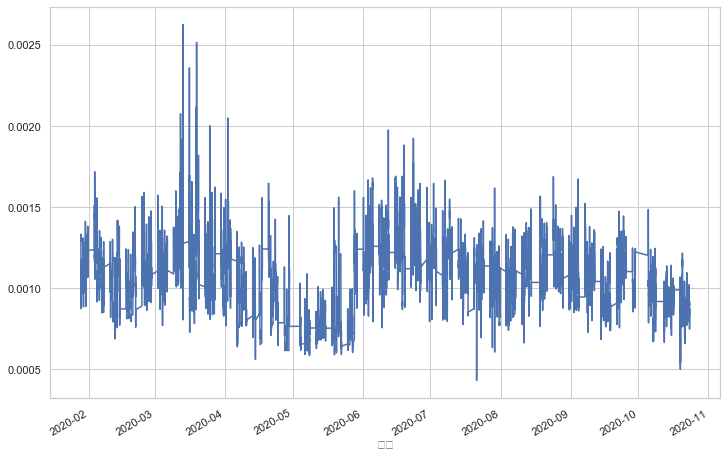

In [53]:
vol.plot(figsize = (12, 8))

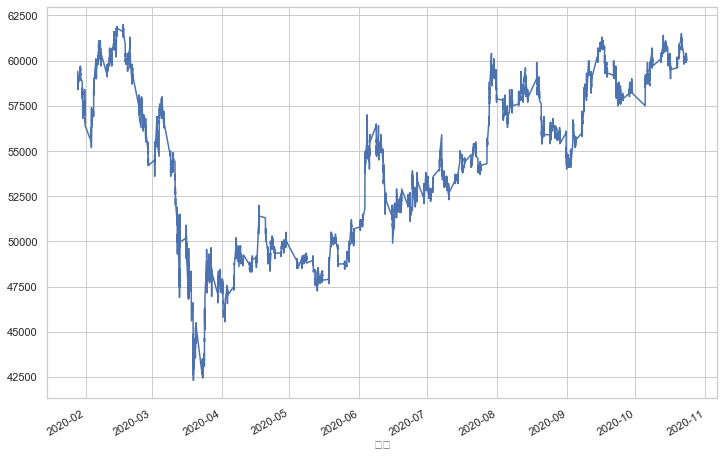

In [54]:
val_2_500.close.plot(figsize = (12, 8))

In [55]:
class CorwinShultz:
    """
    A class that encapsulates all the functions for Corwin and Shultz estimator
    """

    @staticmethod
    def get_beta(high, low, sample_length):
        """
        Computes beta in Corwin and Shultz bid-ask spread estimator

        :param high: a series of high prices
        :param low: a series of low prices
        :param sample_length: number of values per sample
        :return: beta estimate
        """
        log_high_low = np.log(high / low) ** 2
        sum_neighbors = log_high_low.rolling(window=2).sum()
        beta = sum_neighbors.rolling(window=sample_length).mean()
        return beta

    @staticmethod
    def get_gamma(high, low):
        """
        Computes gamma in Corwin and Shultz bid-ask spread estimator

        :param high: a series of high prices
        :param low: a series of low prices
        :return: gamma estimate
        """
        high_over_2_bars = high.rolling(window=2).max()
        low_over_2_bars = low.rolling(window=2).min()
        gamma = np.log(high_over_2_bars / low_over_2_bars) ** 2
        return gamma

    @staticmethod
    def get_alpha(beta, gamma):
        """
        Computes alpha in Corwin and Shultz bid-ask spread estimator

        :param beta: Corwin and Shultz beta estimate
        :param gamma: Corwin and Shultz gamma estimate
        :return: aplha estimate
        """
        denominator = 3 - 2 ** 1.5
        beta_term = (np.sqrt(2) - 1) * np.sqrt(beta) / denominator
        gamma_term = np.sqrt(gamma / denominator)
        alpha = beta_term - gamma_term
        alpha[alpha < 0] = 0
        return alpha

    @staticmethod
    def get_becker_parkinson_volatility(beta, gamma):
        """
        Computes Becker-Parkinson implied volatility

        :param beta: Corwin and Shultz beta estimate
        :param gamma: Corwin and Shultz gamma estimate
        :return: volatility estimate
        """
        k2 = np.sqrt(8 / np.pi)
        denominator = 3 - 2 ** 1.5
        beta_term = (2 ** (-.5) -1) * np.sqrt(beta) / (k2 * denominator)
        gamma_term = np.sqrt(gamma / (k2 ** 2 * denominator))
        volatility = beta_term + gamma_term
        volatility[volatility < 0] = 0
        return volatility



def corwin_shultz_spread(high, low, sample_length=1):
    """
    Computes an estimate of the bid-ask spread according to Corwin and Shultz estimator

    :param high: a series of high prices
    :param low: a series of low prices
    :param sample_length: number of values per sample
    :return: spread estimate
    """
    beta = CorwinShultz.get_beta(high, low, sample_length)
    gamma = CorwinShultz.get_gamma(high, low)
    alpha = CorwinShultz.get_alpha(beta, gamma)
    spread = 2 * (np.exp(alpha) - 1) / (1 + np.exp(alpha))
    return spread

def becker_parkinson_volatility(high, low, sample_length=1):
    """
    Computes implied volatility according Becker-Parkinson method

    :param high: a series of high prices
    :param low: a series of low prices
    :param sample_length: number of values per sample
    :return: volatility estimate
    """
    beta = CorwinShultz.get_beta(high, low, sample_length)
    gamma = CorwinShultz.get_gamma(high, low)
    volatility = CorwinShultz.get_becker_parkinson_volatility(beta, gamma)
    return volatility

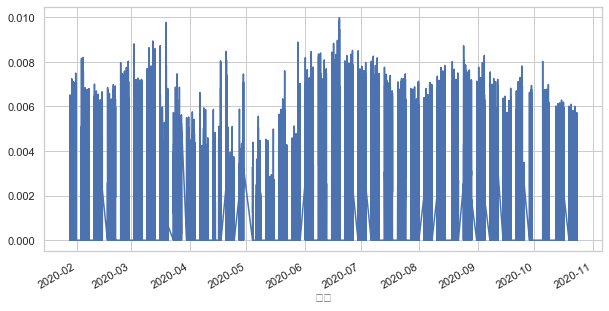

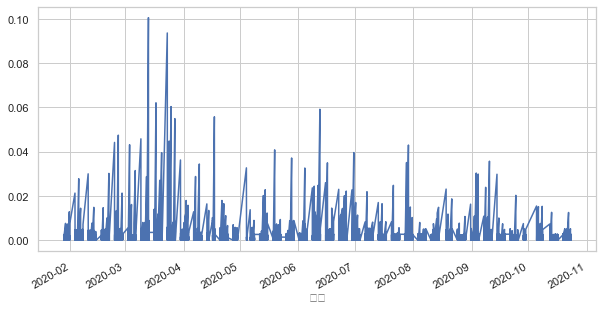

In [56]:

spread = corwin_shultz_spread(val_2_500.high, val_2_500.low, 100)
vol = becker_parkinson_volatility(val_2_500.high, val_2_500.low, 100)

plt.figure(figsize=(10, 5))
spread.plot()
plt.figure(figsize=(10, 5))
vol.plot()

In [63]:
from sklearn.linear_model import LinearRegression
def kyles_lambda(tick_prices, tick_volumes, tick_signs, regressor=LinearRegression()):
    price_change = tick_prices.diff()
    net_order_flow = tick_signs * tick_volumes
    x_val   = net_order_flow.values[1:].reshape(-1, 1)
    y_val = price_change.dropna().values
    lambda_ = regressor.fit(x_val  , y_val)
    return lambda_.coef_[0]
kyles_lambda(df["Price"], df["Volume"], aggressor)

0.00025116805392242964

In [65]:
df

,Date and Time,Price,Volume
0,2020-01-28 09:00:15,59400,1130369
1,2020-01-28 09:00:15,59400,100
2,2020-01-28 09:00:15,59400,10
3,2020-01-28 09:00:15,59400,8333
4,2020-01-28 09:00:15,59400,100
...,...,...,...
17484738,2020-10-23 15:19:58,60100,100
17484739,2020-10-23 15:19:58,60100,3
17484740,2020-10-23 15:19:59,60100,10
17484741,2020-10-23 15:19:59,60000,1


In [71]:
def amihuds_lambda(close, dollar_volume, regressor=LinearRegression()):
    log_close = np.log(close)
    abs_change = np.abs(log_close.diff())
    x_val   = dollar_volume.values[1:].reshape(-1, 1)
    y_val = abs_change.dropna()
    lambda_ = regressor.fit(x_val  , y_val)
    return lambda_.coef_[0]